# **Deployment**

**Replicaset 복습**

* ReplicaSet은 Deployment로 의도한 Pod 개수에 대한 가용성을 보증하는데 사용
* 애플리케이션 동작이 지속적으로 되도록 보장하므로 만약 워커노드 하나가 죽으면 워커노드 위에 동작중이던 모든 Pod가 죽지만 RepliacaSet은 의도한 Pod 개수를 충족하기 위해 다른 워커 노드에 새로운 Pod를 띄워 개수를 맞춘다. 
* (즉 지정된 Pod 개수만큼 추가하고 만약 초과되면 삭제한다.)

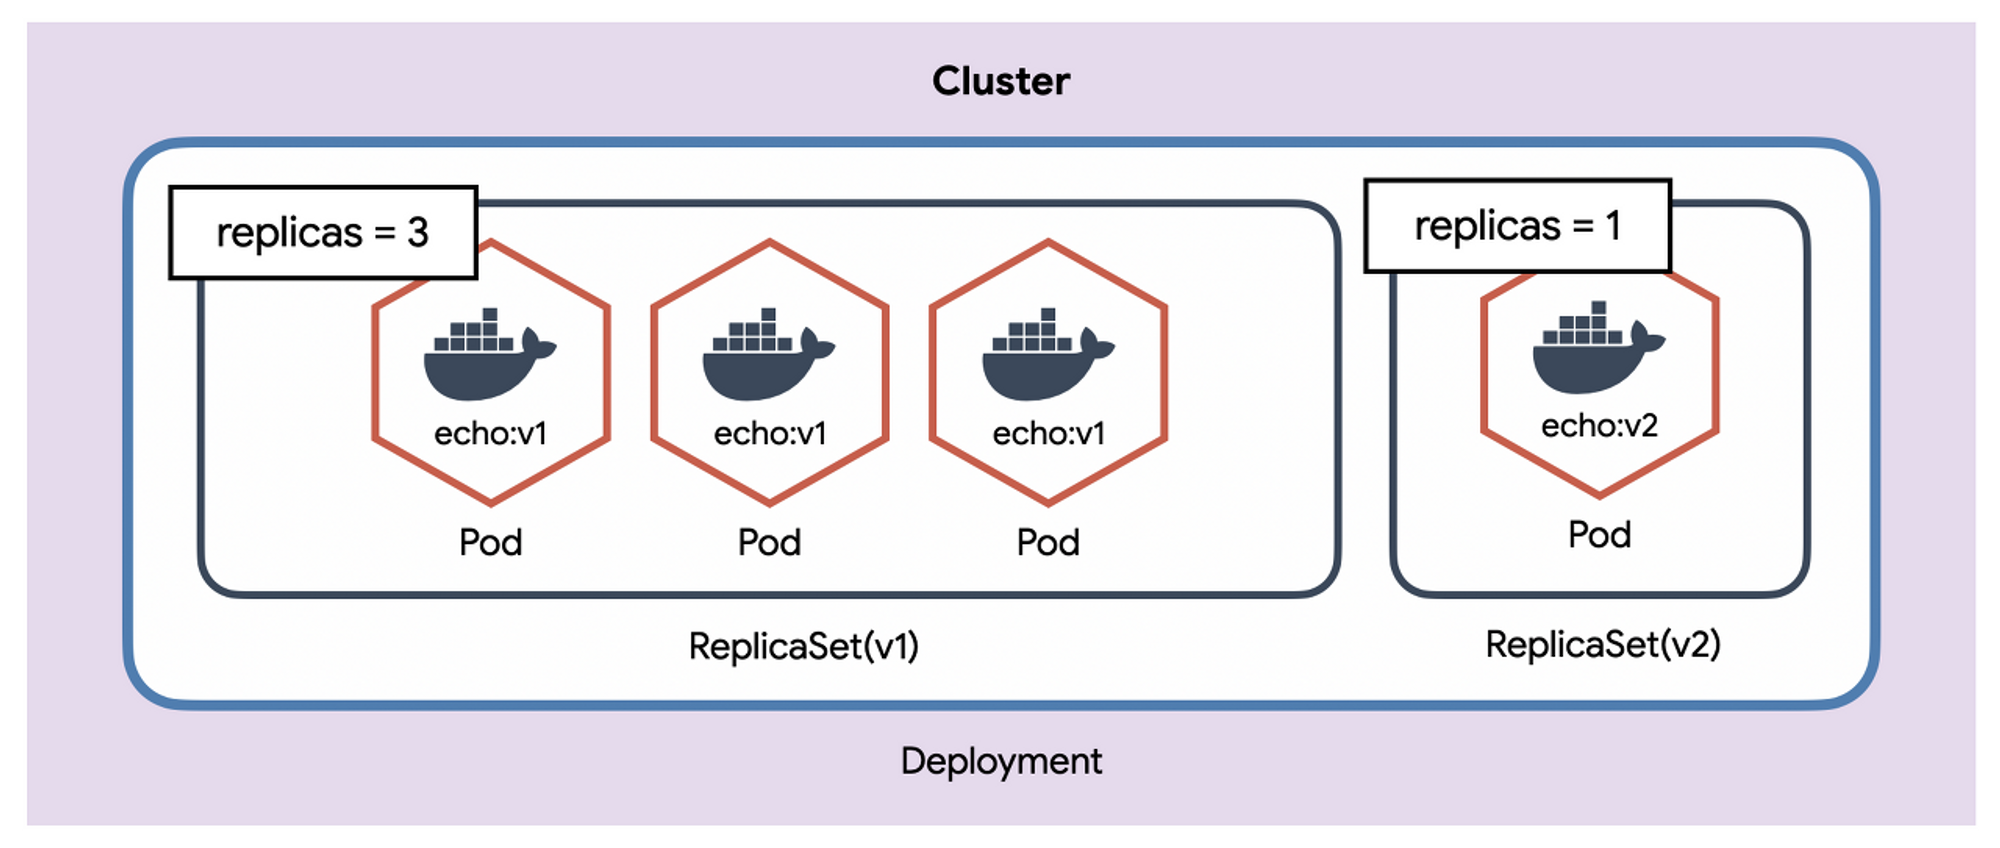

* 레플리카셋은 labelSelector의 조건에 따라 파드를 검색하여 가동 중인 파드의 수가 매니페스트 파일의 replicas의 수와 일치하는지 아닌지를 확인.
* 가동중인 파드의 수가 부족한 경우 새로 파드를 추가하고, 파드의 수가 많을 때는 여분의 파드를 정지시킨다. 
* 가동 중인 애플리케이션의 파드 수를 변경하고 싶을 때는 레플리카셋의 replicas의 값을 수정하기만 하면 된다.

### ****ReplicaSet의 한계****

* 레플리카셋은 지정한 수의 파드가 항상 실행되고 있다는 것을 보증하는 장치이지만 **버전 관리를 하는 장치는 가지고 있지 않다.** 
*  프로젝트에서 이용할 때는 레플리카셋의 상위 레벨의 개념으로 만들어진 디플로이먼트(Deployment)를 이용하는 것이 좋다. 디플로이먼트를 사용하면 롤링 업데이트를 할 수 있다.

### ****ReplicaSet의 동작****

* 클러스터 안에서 파드를 정한 수 만큼 실행시켜 두려면 **클러스터의 상태를 항상 감시하여 제어하는 장치**가 필요하다. 이 역할을 **컨트롤러라고** 부름. 
* 컨트롤러의 기본적인 움직임은 다음과 같다.

1. 클러스터(X)의 현재 상태를 확인
2. 클러스터(Y)가 본래 되어 있어야 할 상태를 확인
3. X == Y
    - true : 아무 것도 하지 않는다.
    - false : 컨테이너를 시작/재시작 또는 중지

* 쿠버네티스는 이 처리를 반복함으로써 클러스터의 상태를 확인하고 원래의 모습, 즉 매니페스트에 정의된 상태로 되어 있는 지를 감시하고 본연의 모습이 되도록 자동으로 복구.

# **DeployMent란**

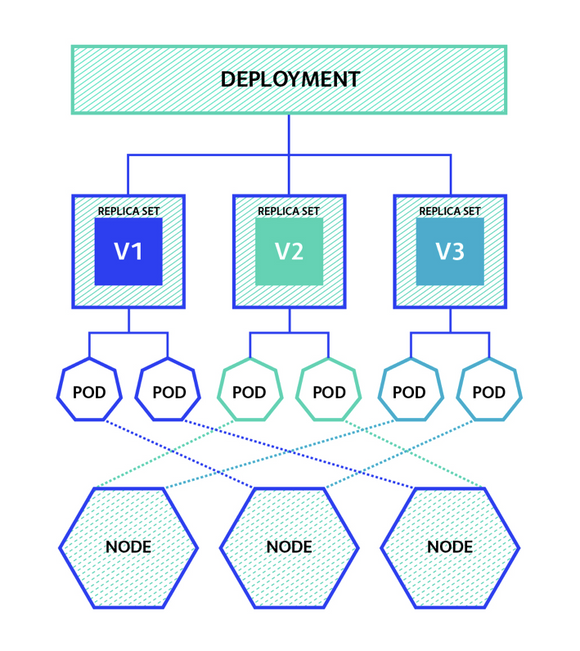

* Kubernetes에서 어플리케이션 단위를 관리하는 Controller
* Kubernetes의 최소 유닛인 Pod에 대한 기준스펙을 정의한 Object이다. 
* Kubernetes에서는 각 Object를 독립적으로 생성하기 보다는 Deployment를 통해서 생성하는 것을 권장하고 있으며, Pod와 ReplicaSet의 기준정보를 지정할 수 있다.

### Deployment 사용법

**Deplyment 생성**

```bash
apiVersion: apps/v1
kind: Deployment
metadata:
  name: go-gin
spec:
  replicas: 3
  selector:
    matchLabels:
      app: go-gin
  template:
    metadata:
      labels:
        app: go-gin
    spec:
      containers:
        - name: go-gin
          image: tae2089/gin:1.0.1
          ports:
            - containerPort: 8080
```

- apiVersion: 쿠버네티스의 apps/v1을 사용
- kind: Deployment의 작업으로 명시
- metadata.labels.app → Deployment의 레이블을 설정
- spec.replicas → 파드의 개수를 몇개 유지할 것 인지 설정하며 기본값은 1 이다.
- spec.selector → 어떤 레이블의 파드를 선택하여 관리할지에 대한 설정 입니다. 앱 컨테이너의 test-deployment 레이블을 식별하여 해당되는 파드들을 관리하며, 이 필드가 없을 경우 spec.template.metadata.labels에 설정된 내용들을 기본값으로 사용
- spec.template.metadata → 어떤 파드를 실행할지에 대한 정보를 하위에 설정
- spec.template.metadata.name → 생성될 파드의 이름을 지정
- spec.template.metadata.labels.app:test-deployment → 식별하는 레이블이 앱 컨테이너이며 test-deployment 으로 식별
- spec.spec → 이 하위의 옵션들은 컨테이너에 대한 설정을 합니다. 위 코드에선 컨테이너 명, 이미지, 포트를 지정

명령어를 통해 생성.

```bash
kubectl apply -f <deployment파일명>.yaml
```

배포 후, 확인 명령어.

```bash
kubectl get deployment, replicaset, pods
```

**Deployment 업데이트**

디플로이먼트를 사용하여 이미지의 버전을 업데이트하거나 할 수 있다.



```
kubectl set image deployment/[디플로이먼트이름] [컨테이너이름]=[이미지]:[버전]
```




**Deployment Replica 갯수 조절**

deployment의 replica 갯수를 변경하고 싶을때가 있다. 이때 scale 명령어를 사용하면 replica 갯수를 줄이고 늘릴 수 있음.



```
kubectl scale --replicas=10 deployment <deployment명>
```



**Deployment 롤백 및 롤아웃 기록 조회**

디플로이먼트를 이용하여 이전 작업으로 되돌아가거나, 작업했던 기록을 살펴볼 수 있다. 롤아웃 기록은 기본적으로 10까지 저장하며 더 많은 기록을 저장하기 위해서는 따로 설정이 필요하다. 

* 롤아웃 기록 조회 명령.

```bash
kubectl rollout history deployment [디플로이먼트 이름]
kubectl rollout undo deployment [디플로이먼트 이름] --to-revision=[숫자]
```


**Deployment 롤아웃 기록에 Change-Cause 남기기**

* kubectl edit deployment [디플로이먼트 이름] 을 입력하여 vi 편집기로 진입한다. 이후 가장 상단에 있는 metadata.annotations에 kubernetes.io/change-cause: [기록할 단어] 를 입력한 후 :wq 로 저장하고 나오면 끝.

* 롤백을 진행하면 아래와 같이 CHANGE-CAUSE에 기록이 남는걸 볼 수 있고, 아래 이미지의 경우 테스트하는 과정에서 히스토리가 남는다. 이와 같이 버전을 남겨서 기록을 관리할 수 있다.

```
kubectl rollout history deployment [디플로이먼트 이름]
```

**Deployment 일시정지, 시작, 재시작**

* 쿠버네티스의 디플로이먼트는 배포 작업을 잠시 일시 중지 시켰다가 시작할 수도, 재시작 할 수도 있음.

```bash

kubectl rollout pause deployment/[디플로이먼트 이름]
kubectl rollout resume deployment/[디플로이먼트 이름]
kubectl rollout restart deployment/[디플로이먼트 이름]
```

**Deployment 배포 방식**

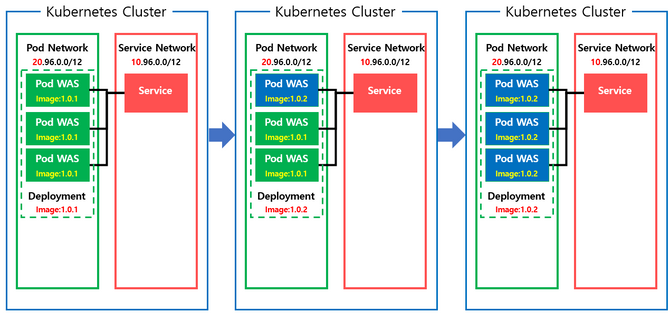

* Rolling Update( Deployment )Rolling Update는 가장 많이 사용되는 Update 방법

* Replication Controller에서 지원하다 ReplicaSet의 등장으로 Replication Controller이 없어지고 ReplicaSet을 사용하는 Deployment Controller에서  지원되는 Update 방법.

* 실제 Update는 Deployment Controller가 아니라 Replication에 의해서 이루어짐.

* 전체 배포되어 있는 모든 Pod들을 동시에 중단/Update 하는 것이 아니라일정 개수씩 순서대로 Update 하는 방법

**장점**

* 서비스 중단 현상 없이 Update/Rollback 가능.

**단점**

* 구버전과 새 버전이 공존하는 시간이 발생함.

작성법

```yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: iksoon-deployment
  labels:
    app: iksoon-tomcat
spec:
  replicas: 10
  minReadySeconds: 1
  strategy:  
    type: RollingUpdate
    rollingUpdate:
      maxSurge: 1
      maxUnavailable: 0
  selector:
    matchLabels:
      app: iksoon-pod
  template:
    metadata:
      labels:
        app: iksoon-pod
    spec:
      containers:
      - name: iksoon-tomcat
        image: peksoon/iksoon_tomcat:1.0.3
        ports:
        - containerPort: 8080
```

**[옵션 설명]**

* minReadySeconds -  Rolling Update 속도 설정으로 기본 값은 0. Pod의 status 가 Ready가 될 때까지의 최소 대기 시간. minReadySeconds로 설정된 시간 동안은 트래픽을 받지 않음

* type : RollingUpate - 설정하지 않으면 자동으로 RollingUpdate로 설정됨 (Default 값) Update 시 Rolling Updaet를 사용

* maxSurge -  Rolling Update 시 동시에 생성할 수 있는 Pod의 최대 개수 설정.

* % 혹은 수로 설정 가능하며 수로 설정 시 0보다 큰 수로 설정 필요. 기본값은 replicas설정 값의 25%. 해당 설정에 따라서 Update 시간을 단축할 수도 있으나 갑자기 Pod 리소스가 급증할 수도 있으니 주의해야 함

* maxUnvailable -  Rolling Update 시 동시에 삭제할 수 있는 Pod의 최대 개수 설정

* % 혹은 수로 설정 가능하며 수로 설정 시 0보다 큰 수로 설정 필요. 기본값은 replicas설정 값의 25%. 해당 설정에 따라서 Update 시간을 단축할 수도 있으나 갑자기 Pod 리소스가 급증할 수도 있으니 주의해야 함

**Blue/Green Update(Deployment)**

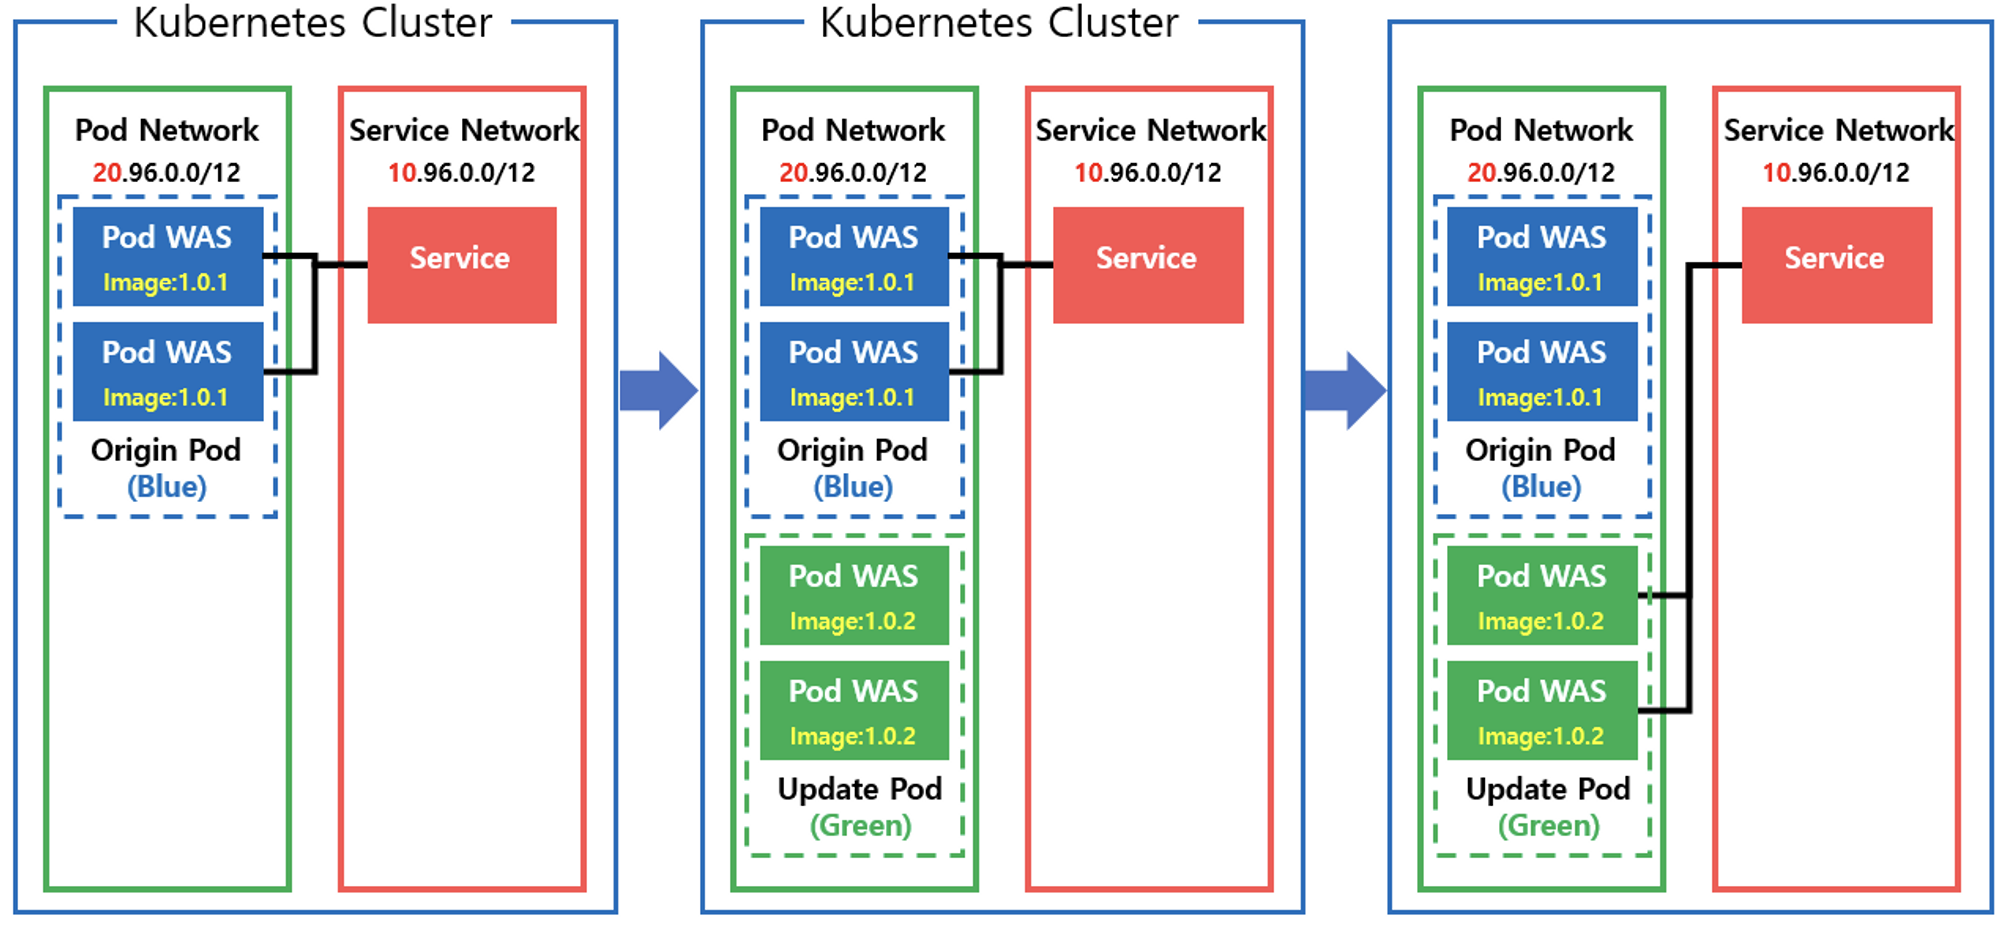

1. Blue/Green은 기존에 띄워져 있는 Pod 개수와 동일한 개수만큼의 신규 Pod를 모두 띄운 다음

2. 신규 Pod가 이상 없이 정상적으로 떴는지 확인 후

3. 들어오는 트래픽을 LoadBalaner 설정을 변경하여 한번에 신규 Pod 쪽으로 옮기는 방법

4. 서버를 새 버전과 구버전으로 2세트를 마련하고, 이를 한꺼번에 교체하는 방법.

**Blue 의미**

* 운영 중인 Application (Old Version)

**Green 의미**

* 새로운 버전의 Application (New Version)

* Unit Test, Smoke Test, 스트레스 Test 등 각종 Test를 수행

**진행**

* 테스트가 완료되고 이상이 없음을 확인하면

* Blue Application으로 가던 트래픽을 Green Application으로 변경하여 Update를 완료함

* 이후에 지속적으로 Green을 모니터링하다가 버그/오류가 발생하면 다시 Blue로 변경하고

* Green에서 장시간 정상 동작을 확인하면 Blue를 제거한 후 Green을 Blue로 사용함

**장점**

* 릴리즈와 관련된 모든 downtime을 줄이기 위한 Application Release 기술.

* 앱을 출시하기 전에 준비하는 매우 빠른 방법이며,

* 배포판의 Issue가 감지되었을 시 빠르게 Rollback을 할 수 있음

**단점**

* 한 번에 두배의 Pod를 실행해야 하기 때문에 클러스터의 리소스가 2배 이상 필요함.

**Canary Update(Deployment)**

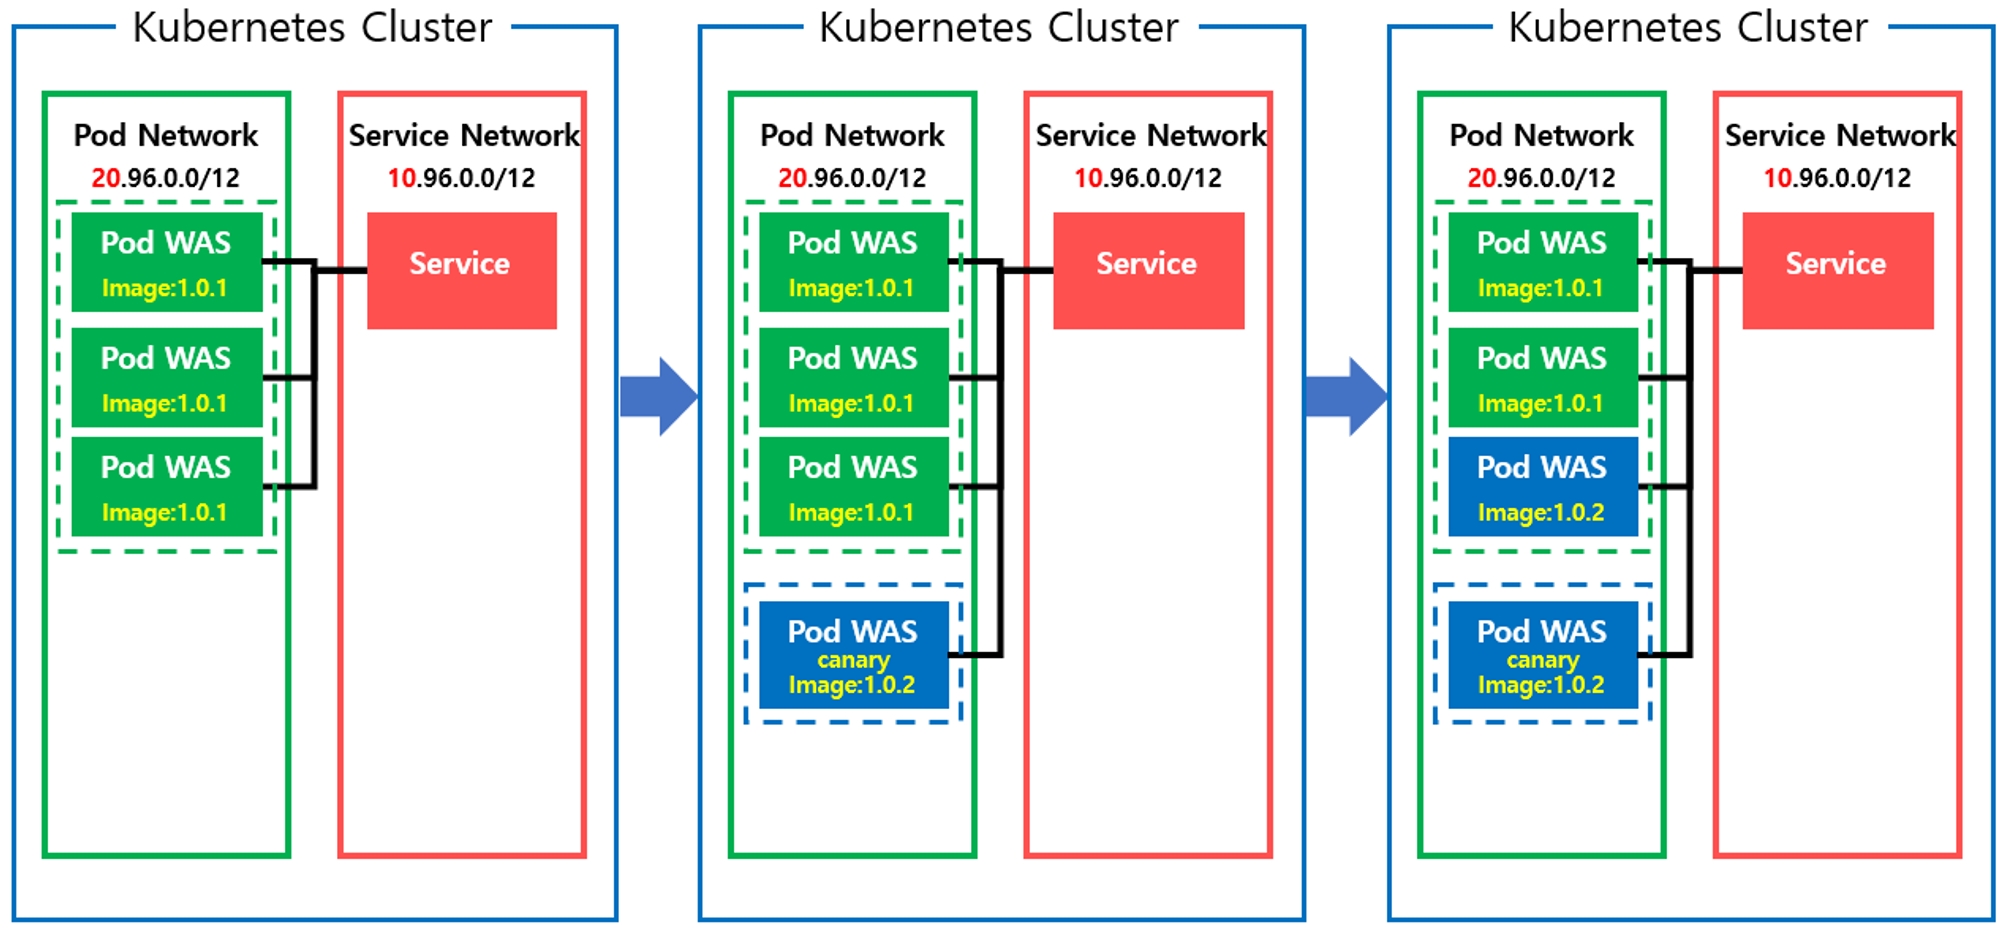

* 신규 버전을 배포할 때 한꺼번에 앱의 전체를 교체하는 게 아니라 기존 버전을 유지한 채로 일부 버전만 신규 버전으로 올려서신규 버전에 버그나 이상은 없는지를 사용자 반응은 어떤지 확인하는데 유용하게 사용하는 방법.

* 즉 새로운 버전의 Application을 Production 환경으로 보내어 어떻게 동작하는지 모니터링하는 도구로 사용

* Kubernetes의 기본 Deployment로는 Deployment에 속한 Pod들을 하나씩 / 한꺼번
에 모두 교체하는 방식이기 때문에 이런 Canary 배포를 하기에는 어려움이 있음.

* 하지만 라벨을 이용하면 Kubernetes에서도 Canary 배포를 할 수 있음.